# Sesión 11 B

## Inferencia exacta

> **Objetivos:**
> - Describir intuitivamente el algoritmo de eliminación de variables.
> - Usar el algoritmo suma-producto para resolver preguntas de probabilidad condicional.
> - Usar el algoritmo max-suma para resolver preguntas de MAP.

> **Referencias de interés:**
> - _Probabilistic Graphical Models: Principles and Techniques_ - Capítulo 9. Exact Inference: Variable Elimination. Pages 287. MIT Press.

### 1. Algoritmo de eliminación de variables (Suma-Producto)

El algoritmo de eliminación de variables es un **método exacto** para calcular probabilidades marginales o condicionales en una red bayesiana.

Su objetivo es **evitar construir la distribución conjunta completa**, reduciendo el número de _multiplicaciones_ y _sumas_ necesarias.


#### Idea principal:

En lugar de calcular todo $P(X_1, X_2, ..., X_n)$ y luego marginalizar,
vamos **eliminando las variables una por una**, combinando solo los factores que las contienen.

Así, se minimiza el número de operaciones y el tamaño de los factores intermedios.


#### Pasos del algoritmo

El proceso de eliminar alguna variable $Z$ de un conjunto de factores $\bar{\Phi}$, se puede describir como:

1. Determinar el conjunto de factores que involucran a la variable $Z$:

   $$\Phi' = \left\{\phi_i \in \Phi : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Calcular el producto:

   $$\psi = \prod_{\phi_i \in \Phi'} \phi_i$$
   
3. Calcular la marginalización:

   $$\tau = \sum_Z \psi$$
   
4. Sobreescribir el conjunto de factores original:
   
   $$\bar{\Phi} := \left(\bar{\Phi}\setminus \Phi'\right) \cup \{\tau\}$$


```{admonition} Nota
:class: tip
Por tanto, el algoritmo completo puede describirse como:

1. El primer paso es reducir todos los factores de acuerdo a la evidencia, si es que hay.

2. Para cada variable $Z$ que no sea de interés:
   - Eliminar la variable $Z$ de $\bar{\Phi}$.

3. Multiplicar los factores restantes.
```

#### Veámos un ejemplo

##### Restaurante

Variables:
- Ubicación $L$ (Bad: $l^0$, Good: $l^1$).
- Calidad $Q$ (Bad: $q^0$, Normal: $q^1$, Good: $q^2$).
- Costo $C$ (Low: $c^0$, High: $c^1$).
- Número de personas $N$ (Low: $n^0$, High: $n^1$).

![](../images/sesion11-modelo-res.png)

**Figura 1.** Modelo gráfico de restaurante.

In [1]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import os

In [2]:
import pickle

ruta = os.path.join('..', 'data', 'restaurant_model.pkl')
with open(ruta, "rb") as f:
    restaurant_model = pickle.load(f)

print(type(restaurant_model))

<class 'pgmpy.models.DiscreteBayesianNetwork.DiscreteBayesianNetwork'>


In [3]:
VariableElimination?

Init signature: VariableElimination(model)
Docstring:     
Base class for all inference algorithms.

Converts DiscreteBayesianNetwork and MarkovNetwork to a uniform representation so that inference
algorithms can be applied. Also, it checks if all the associated CPDs / Factors are
consistent with the model.

Initialize inference for a model.

Parameters
----------
model: pgmpy.models.DiscreteBayesianNetwork or pgmpy.models.MarkovNetwork
    model for which to initialize the inference object.

Examples
--------
>>> from pgmpy.inference import Inference
>>> from pgmpy.models import DiscreteBayesianNetwork
>>> from pgmpy.factors.discrete import TabularCPD
>>> student = DiscreteBayesianNetwork([('diff', 'grade'), ('intel', 'grade')])
>>> diff_cpd = TabularCPD('diff', 2, [[0.2], [0.8]])
>>> intel_cpd = TabularCPD('intel', 2, [[0.3], [0.7]])
>>> grade_cpd = TabularCPD('grade', 3, [[0.1, 0.1, 0.1, 0.1],
...                                     [0.1, 0.1, 0.1, 0.1],
...                         

In [4]:
infer = VariableElimination(restaurant_model)

La función ``query()`` calcula probabilidades exactas de una o más variables.

In [5]:
infer.query?

Signature:
infer.query(
    variables,
    evidence=None,
    virtual_evidence=None,
    elimination_order='greedy',
    joint=True,
    show_progress=True,
)
Docstring:
Parameters
----------
variables: list
    list of variables for which you want to compute the probability

evidence: dict
    a dict key, value pair as {var: state_of_var_observed}
    None if no evidence

virtual_evidence: list (default:None)
    A list of pgmpy.factors.discrete.TabularCPD representing the virtual
    evidences.

elimination_order: str or list (default='greedy')
    Order in which to eliminate the variables in the algorithm. If list is provided,
    should contain all variables in the model except the ones in `variables`. str options
    are: `greedy`, `WeightedMinFill`, `MinNeighbors`, `MinWeight`, `MinFill`. Please
    refer https://pgmpy.org/exact_infer/ve.html#module-pgmpy.inference.EliminationOrder
    for details.

joint: boolean (default: True)
    If True, returns a Joint Distribution over `va

La probabilidad conjunta es:

$$P(L,Q,C,N)= \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C)$$

Si queremos calcular $P(N)$:

In [6]:
p_N = infer.query(
    variables=["N"],
    elimination_order=["Q", "C", "L"]
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(p_N)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


**¿Qué sucede si tenemos evidencia?**

Ahora, calculemos $P(N, L=l^1)$:

- Primero, debemos reducir nuestros factores de acuerdo a la evidencia: $\phi_L(l^1)=\phi_L'()$, $\phi_C(C,l^1,Q)=\phi_C'(C,Q)$, $\phi_N(N,l^1,C)=\phi_N'(N,C)$.
- Después, ejecutamos el algoritmo normalmente:

In [8]:
p_N_given_l1 = infer.query(variables=["N"],
                           evidence={"L": 1},
                           elimination_order=["Q", "C"])

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
print(p_N_given_l1)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.3120 |
+------+----------+
| N(1) |   0.6880 |
+------+----------+


#### 1.2. Importancia del orden de eliminación

Por ejemplo, retomamos el ejemplo del restaurante.

1. $Q-C-L$
   
   - Operación: $\tau_1(C,L)=\sum_{Q}\phi_Q(Q)\phi_C(C,L,Q)$
   
   - Operación: $\tau_2(N,L)=\sum_{C}\phi_N(N,L,C)\tau_1(C,L)$

   - Operaración: $\tau_3(N)=\sum_{L}\phi_L(L)\tau_2(N,L)$

In [10]:
%timeit p_N = infer.query(variables=["N"], elimination_order=["Q", "C", "L"], show_progress=False)

922 μs ± 20.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
print(p_N)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


2. $L-C-Q$

   - Operación: $\tau_1(Q,C,N) = \sum_{L} \phi_L(L) \phi_C(C,L,Q) \phi_N(N,L,C)$

   - Operación: $\tau_2(Q,N) = \sum_{C} \tau_1(Q,C,N)$

   - Operación: $\tau_3(Q) = \sum_{Q} \phi_Q(Q)\tau_2(Q,N)$

In [12]:
%timeit infer.query(variables=["N"], elimination_order=["L", "C", "Q"], show_progress=False)

924 μs ± 11 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### 1.3. ¿Cómo elegir el orden de eliminación?

En la práctica, se usan estrategias heurísticas de orden de eliminación. ``pgmpy`` ofrece estas opciones dentro del módulo ``pgmpy.inference.EliminationOrder``.

> Estas heurísticas ayudan a elegir en qué orden eliminar variables en el algoritmo de Variable Elimination, para minimizar el costo computacional.


* `MinFill`
* `MinNeighbors` 
* `MinWeight` 
* `WeightedMinFill`

![](../images/sesion11-docu.png)

**Figura 2.** [Documentación](https://pgmpy.org/exact_infer/ve.html) de ``pgmpy`` sobre heurísticas de orden de eliminación. 

##### 1.3.1. Heurísticas de orden de eliminación

El **Algorithm 9.4** busca construir ese orden mediante un enfoque _greedy_: en cada paso elimina la variable que minimiza un costo heurístico _(por ejemplo MinFill, MinNeighbors, MinWeight, etc.)_.

![Heurísticas de orden de eliminación](../images/sesion11-greedy-algorithm.png)

**Figura 3.** Algoritmo _greedy_ para la construcción de un orden de eliminación de variables. _Koller & Friedman (2009, Capítulo 9)._

<details>
<summary> 💡 Explicación del algoritmo </summary>

<details>
<summary>🔹Comienzo </summary>

$H$ es el grafo no dirigido (moral graph) que representa las dependencias entre las variables.

$s$ es una función de evaluación _(heurística)_ que mide el costo de eliminar una variable (por ejemp. MinFill, MinNeighbors, etc.).
</details>

<details>

<summary>🔹Cuerpo </summary>

* Se comienza con todas las variables. `Initialize all nodes in $X$ as unmarked`

* Se realizarán tantas iteraciones como variables haya en la red (una por variable eliminada). `For k=1...|X|`

* En cada paso:
    * se evalúa cada variable según la heurística $s$.
    * se elige la que minimiza el costo.

* Se asigna a la variable $X$ la posición $k$ en el orden de eliminación $\pi$ (orden final).

* Antes de "eliminar" $X$, se conectan entre sí todos sus vecinos (esto genera los llamados "fill-in edges"). De este modo se preservan las dependencias necesarias para el cáculo posterior.

* Se marc $X$ como "eliminada" (ya no se considera en las siguientes iteraciones).
</details>

<details>
<summary>🔹Return </summary>

* Al final, el algoritmo devuelve el orden de eliminación $\pi$ que se usará para realizar la inferencia exacta.
</details>

</details>

---

* ``MinFill``

El algoritmo **MinFill** busca el orden más eficiente para eliminar variables en inferencia exacta. 

Su idea es sencilla:

> Si elimino tal nodo, ¿cuántas conexiones nuevas tendría que crear entre sus vecinos?

El nodo que menos conexiones nuevas _(fill-ins)_ requiera, se elimina primero.

En la siguiente imagen, se muestra un ejemplo del funcionamiento de la heurística ``MinFill``.

1. **Grafo original**: modelo dirigido con dependencias.
2. **Grafo moralizado**: se quitan las direcciones y se conectan los padres comunes.
3. **Eliminación de nodos**: se elimina el nodo que genera menos conexiones nuevas entre sus vecinos.

```MinFill``` elegiría eliminar **$Q$** o **$N$** primero, ya que generan **menos conexiones nuevas (1)**.

![heuristic-minfill](../images/sesion11-minfill.png)

**Figura 4.** Ejemplo del funcionamiento de la heurística ``MinFill``. 

In [13]:
%timeit infer.query(variables=["N"], elimination_order="MinFill", show_progress=False)

1.63 ms ± 45.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---

* ``MinNeighbors``

El algoritmo **MinNeighbors** propone una forma de decidir el orden de eliminación de variables en inferencia exacta.

A diferencia de _MinFill_, no evalúa nuevas conexiones posibles, sino la **cantidad actual de conexiones**.

> Si elimino tal nodo, ¿cuántos vecinos (conexiones actuales) tiene?

De esta manera, se evita eliminar nodos muy conectados que podría generar factores grandes y costosos.

En la siguiente imagen, se muestra un ejemplo del funcionamiento de la heurística ``MinNeighbors``.

1. **Grafo original**: modelo dirigido con dependencias.
2. **Grafo moralizado**: se quitan las direcciones y se conectan los padres comunes.
3. **Eliminación de nodos**: se elimina primero el nodo con menos vecinos en el grafo actual.

``MinNeighbors`` eligiría eliminar **$Q$** o **$N$** primero, ya que tienen **menos vecinos (2)**.

![heuristic-minneighbors](../images/sesion11-minneighb.png)

**Figura 5.** Ejemplo del funcionamiento de la heurística ``MinNeighbors``.

In [14]:
%timeit infer.query(variables=["N"], elimination_order="MinNeighbors", show_progress=False)

1.63 ms ± 42 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---

* ``MinWeight``

El algoritmo **MinWeight** selecciona el orden de eliminación de variables considerando el **peso de los vecinos** de cada nodo.

El peso de una variable se asocia con su _cardinalidad_ (número de estados posibles).

> Si elimino tal nodo, el costo depende del producto de los tamaños de dominio (pesos) de sus vecinos.

El nodo cuyo producto de pesos sea **menor** se elimina primero, ya que su eliminación implicaria la creación de factores más pequeños y menos costosos de manejar. 

**Cálculo del costo (producto de pesos de los vecinos)**

| Variable | Vecinos | Producto de cardinalidades | Costo |
|-----------|----------|----------------------------|--------|
| $L$ | $\{Q, C, N\}$ | $3 \times 2 \times 2 = \mathbf{12}$ | alto |
| $Q$ | $\{L, C\}$ | $2 \times 2 = \mathbf{4}$ | bajo  |
| $C$ | $\{L, Q, N\}$ | $2 \times 3 \times 2 = \mathbf{12}$ | alto |
| $N$ | $\{L, C\}$ | $2 \times 2 = \mathbf{4}$ | bajo  |

``MinWeight`` elegiría eliminar **$Q$** o **$N$** primero, ya que tienen **menor costo ($4$)**.

![heuristica minweight](../images/sesion11-minweight.png)

**Figura 6.** Ejemplo del funcionamiento de la heurística ``MinWeight``.

In [15]:
%timeit infer.query(variables=["N"], elimination_order="MinWeight", show_progress=False)

1.71 ms ± 75 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

* ```WeightedMinFill```

El algoritmo **WeightedMinFill** combina las ideas de **MinFill** y **MinWeight**.  
Evalúa no solo cuántas conexiones nuevas (*fill-ins*) se crean al eliminar un nodo,  
sino también **el peso** de esas conexiones, considerando el tamaño del dominio de las variables involucradas.

> Si elimino tal nodo, el costo es la suma de los pesos (productos de cardinalidades) de las nuevas aristas que tendría que agregarse entre sus vecinos.

El nodo con **menos costo ponderado** se elimina primero.

**Cálculo del costo ponderado**

Supongamos que queremos eliminar **$C$**.  
Sus vecinos son $\{L, Q, N\}$.

Entre ellos, falta la conexión **$Q$–$N$**, por lo que hay **1 fill-in**.

El **peso** de esa nueva arista se calcula como el **producto de los tamaños de dominio** de las variables conectadas:

$$
\text{Peso}(Q, N) = |\text{dom}(Q)| \times |\text{dom}(N)| = 3 \times 2 = 6
$$

Por lo tanto, el **costo de eliminar $C$** es:

$$
\text{Coste}(C) = 6
$$

Si otro nodo genera más aristas nuevas o con variables de mayor cardinalidad, su costo será mayor y se eliminará después.


![heuristic-minneighbors](../images/sesion11-minweightfill.png)

**Figura 7.** Ejemplo del funcionamiento de la heurística ``WeightedMinFill``.

In [16]:
%timeit infer.query(variables=["N"], elimination_order="WeightedMinFill", show_progress=False)

1.58 ms ± 26.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---

```{admonition} Recomendaciones
:class: tip

Ninguna de estas heurísticas es "perfecta" -ninguna garantiza siempr el mejor orden-, pero en la práctica suelen funcionar bien.

`MinFill` y `weightedMinFill` suelen ser las más eficaces.

`WeightedMinFill` destaca cuando hay gran variabilidad en los tamaños de los dominios de las variables.
```

### 2. Eliminación max-producto (MAP)

Hasta ahora hemos visto el algoritmo de eliminación de variables para calcular probabilidades marginales o condicionales usando suma-producto.

Recordemos que este algoritmo funciona con **consultas de la forma: probabilidad concidicional**.

Sin embargo, cuando _tenemos consultas de la forma "máxima probabilidad a posteriori" (MAP)_, necesitamos una variante del algoritmo que utilice la operación de _maximización_ en lugar de _suma_.



#### Algoritmo max-producto
   
1. Determinar el conjunto de factores que involucran a la variable $Z$:

   $$\Phi' = \left\{\phi_i \in \Phi : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Calcular el producto:

   $$\psi = \prod_{\phi_i \in \Phi'} \phi_i$$
   
3. Calcular la max-marginalización:

   $$\tau = \max_Z \psi$$
   
   **Y guardar la variable $z^\ast$ que maximiza $\psi$.**
   
4. Sobreescribir el conjunto de factores original:
   
   $$\bar{\Phi} := \left(\bar{\Phi}\setminus \Phi'\right) \cup \{\tau\}$$

``map_query()`` calcula la asignación de variables que maximiza la probabilidad a posteriori.

In [17]:
infer.map_query(variables=["N"])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'N': 1}

In [18]:
infer.map_query(variables=["N"], evidence={"L": 0})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'N': 0}

---

#### Algoritmo max-suma

A menudo, los valores de algunos factores son tan pequeños (probabilidad) que cuando los multiplicamos, producen valores aún más pequeños que la resolución de nuestra memoria: **underflow numérico**.

Una manera efectiva de trabajar con esta situación es considerar el $\log$ de los factores.

Tenemos que:

$$P_{\bar{\Phi}} (\bar{X}) \propto \prod_{k} \phi_{k} (\bar{X}_k)$$

y queremos,

$$\arg \max_{X} \prod_{k} \phi_{k} (\bar{X}_k) = \arg \max_{X} \log\left(\prod_{k} \phi_{k} (\bar{X}_k)\right) = \arg \max_{X} \sum_{k} \log\left(\phi_{k} (\bar{X}_k)\right),$$

dado que el $\log$ es una función creciente.

Así, convirtiendo los factores con el logaritmo, nos permite intercambiar productos por sumas, obteniendo cierta **robustez práctica contra el underflow numérico**.

El algoritmo es completamente análogo:

#### Max-sum variable elimination algorithm

0. Tomar el $\log$ de cada factor:

   $$\theta_k(\bar{X}_k) = \log{\phi_k}(\bar{X}_k).$$
   
   $$\bar{\Theta} = \{\theta_{1}(\bar{X}_1), \dots, \theta_{m}(\bar{X}_m)\}.$$

1. Determinar el conjunto de factores que involucran a la variable $Z$:

   $$\bar{\Theta}' = \left\{\theta_i \in \bar{\Theta} : Z  \in \mathrm{scope}[\theta_i]\right\}$$

2. Calcular la suma:

   $$\psi = \sum_{\theta_i \in \bar{\Theta}'} \theta_i$$
   
3. Calcular la max-marginalización:

   $$\tau = \max_Z \psi$$
   
   **y guardar la variable $z^\ast$ que maximiza $\psi$.**
   
4. Sobreescribir el conjunto de factores original:
   
   $$\bar{\Theta} := \left(\bar{\Theta}\setminus \bar{\Theta}'\right) \cup \{\tau\}$$

### 3. Ejercicio aplicación en clasificacion usando MAP

In [19]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [20]:
iris_data = load_iris()
iris_df = pd.DataFrame(
    data=iris_data.data[:, :2].astype(int),
    columns=iris_data.feature_names[:2]
)
iris_df["species"] = iris_data.target

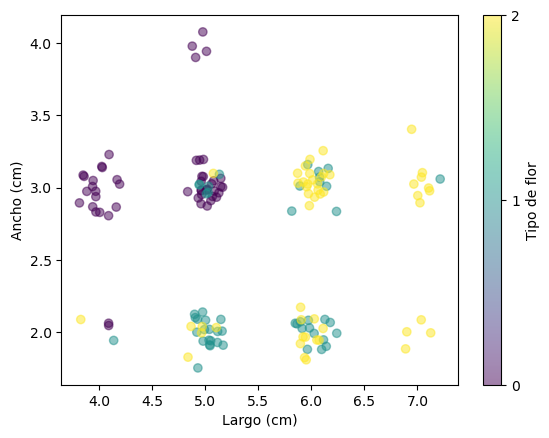

In [21]:
plt.scatter(
    x=iris_df["sepal length (cm)"] + np.random.normal(0, 0.1, size=len(iris_df)),
    y=iris_df["sepal width (cm)"] + np.random.normal(0, 0.1, size=len(iris_df)),
    c=iris_df["species"],
    alpha=0.5,
)
plt.xlabel("Largo (cm)")
plt.ylabel("Ancho (cm)")
plt.colorbar(ticks=[0, 1, 2], label="Tipo de flor")

**Modelo**

In [22]:
iris_model = DiscreteBayesianNetwork([
    ("species", "sepal length (cm)"),
    ("species", "sepal width (cm)"),
])

In [23]:
# Train/test split
train_df = iris_df.sample(frac=0.8, random_state=42)
test_df = iris_df.drop(train_df.index)

El método `fit` de la clase `DiscreteBayesianNetwork`:

> actúa como un _shortcut_ para estimar CPDs al modelo.

[Acá puedes checar la documentación](https://pgmpy.org/examples/Learning%20Parameters%20in%20Discrete%20Bayesian%20Networks.html)

In [24]:
# Entrenamiento del modelo
iris_model.fit(train_df)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'sepal length (cm)': 'N', 'sepal width (cm)': 'N', 'species': 'N'}


In [25]:
iris_model.check_model()

True

In [26]:
print("species cardinalidad: ", iris_df.species.unique())
print("sepal length (cm) cardinalidad: ", iris_df["sepal length (cm)"].unique())
print("sepal width (cm) cardinalidad: ", iris_df["sepal width (cm)"].unique())

species cardinalidad:  [0 1 2]
sepal length (cm) cardinalidad:  [5 4 7 6]
sepal width (cm) cardinalidad:  [3 2 4]


In [27]:
for cpd in iris_model.get_cpds():
    print("CPD de:", cpd.variable)
    df = pd.DataFrame(cpd.values,
                      index=[f"{cpd.variable}({i})" for i in range(cpd.cardinality[0])],
                      columns=[str(state) for state in cpd.state_names[cpd.variables[1]]] if len(cpd.variables) > 1 else None)
    print(df)
    print("-------------------------------------------------------------------------------")

CPD de: species
                   0
species(0)  0.358333
species(1)  0.325000
species(2)  0.316667
-------------------------------------------------------------------------------
CPD de: sepal length (cm)
                             0         1         2
sepal length (cm)(0)  0.395349  0.000000  0.000000
sepal length (cm)(1)  0.604651  0.538462  0.105263
sepal length (cm)(2)  0.000000  0.435897  0.684211
sepal length (cm)(3)  0.000000  0.025641  0.210526
-------------------------------------------------------------------------------
CPD de: sepal width (cm)
                            0         1         2
sepal width (cm)(0)  0.023256  0.666667  0.421053
sepal width (cm)(1)  0.906977  0.333333  0.578947
sepal width (cm)(2)  0.069767  0.000000  0.000000
-------------------------------------------------------------------------------


**¿Lo podemos calcular manualmente? Veámoslo con un ejemplo sencillo.**

In [28]:
# Contar frecuencia conjunta
freq = iris_df.pivot_table(index='sepal length (cm)',
                        columns='species',
                        aggfunc='size',
                        fill_value=0)

# Normalizamos
cpd = freq.div(freq.sum(axis=0), axis=1)
print(cpd)

species              0     1     2
sepal length (cm)                 
4                  0.4  0.02  0.02
5                  0.6  0.50  0.12
6                  0.0  0.46  0.62
7                  0.0  0.02  0.24


El método `predict` de la clase `DiscreteBayesianNetwork`:

> permite predecir los valores de las variables objetivo dadas las variables observadas.

Aquí estaríamos aplicando el algoritmo de **eliminación max-producto (MAP)** para predecir la especie de iris dada la longitud y anchura del sépalo:

In [29]:
predictions = iris_model.predict(test_df.drop(columns=["species"]))

  0%|          | 0/9 [00:00<?, ?it/s]

In [30]:
predictions

,sepal length (cm),sepal width (cm),species
1,4,3,0
14,5,4,0
20,5,3,0
21,5,3,0
37,4,3,0
41,4,2,0
48,5,3,0
52,6,3,2
57,4,2,0
58,6,2,1


In [31]:
# Accuracy
predictions["species"].values == test_df["species"].values

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True, False])

In [32]:
(predictions["species"].values == test_df["species"].values).mean()

np.float64(0.7333333333333333)